In [2]:

import warnings
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from scipy.stats import loguniform, randint

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

sns.set(style="whitegrid")

%matplotlib inline
df = pd.read_csv('D:/music_genre_recognition/Data/features_3_sec.csv')
df = df.drop('filename', axis = 1)

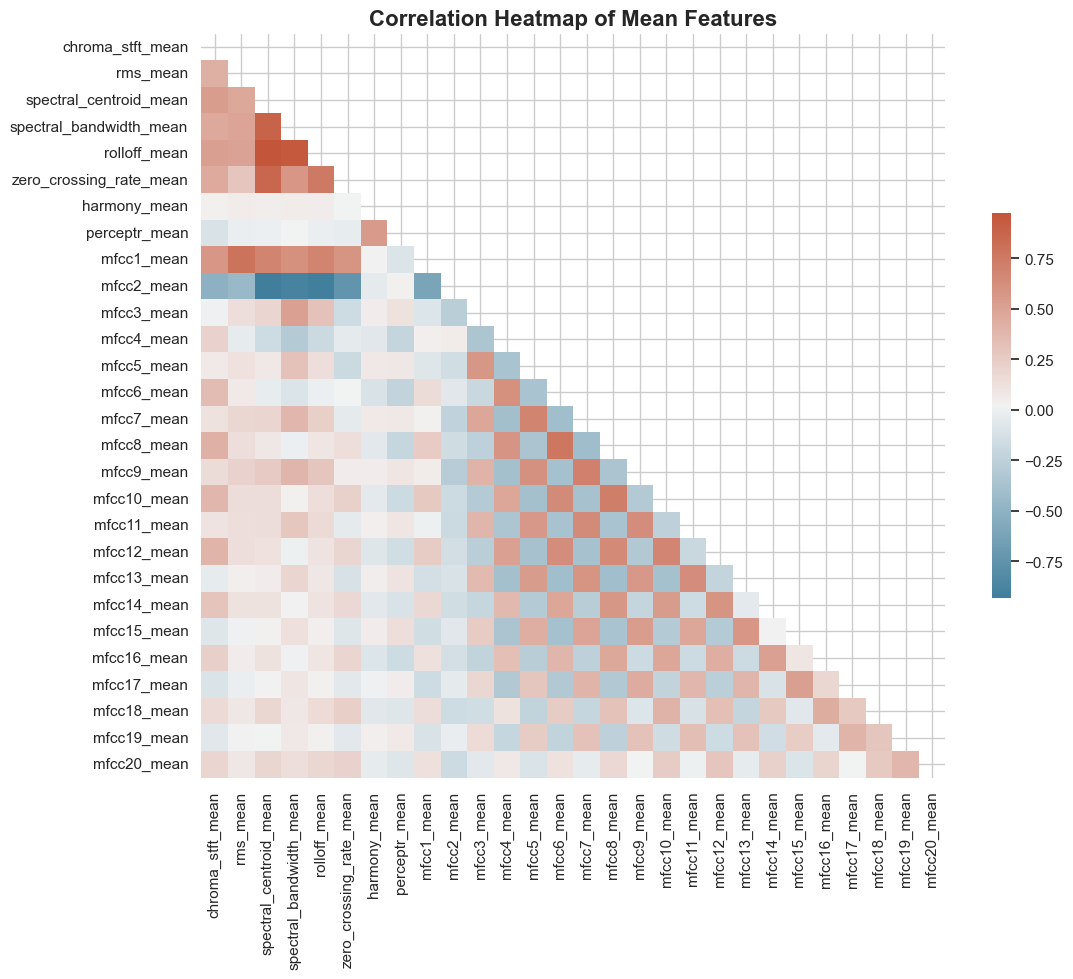

In [3]:
mean_columns = df.filter(regex='_mean$')

correlation_matrix = mean_columns.corr()

# Create a boolean mask for the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=False, linewidths=0,
            cbar_kws={"shrink": .5}, square=True)

# Add a title to the heatmap
plt.title('Correlation Heatmap of Mean Features', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

C:\Users\26630\AppData\Local\Temp\ipykernel_15248\1587322105.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="tempo", data=x, palette='husl')


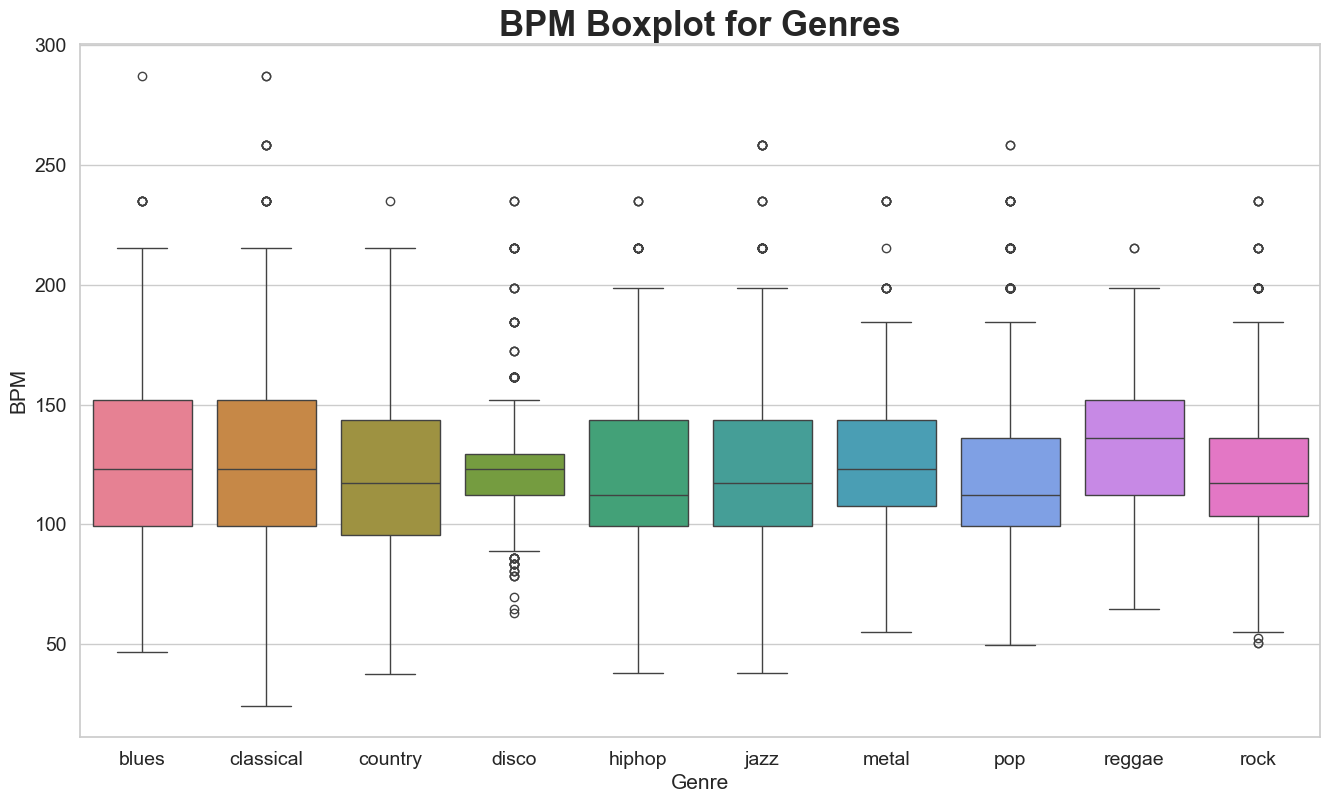

In [4]:
# Subset the DataFrame to include only the 'label' and 'tempo' columns
x = df[["label", "tempo"]]

# Create the plot
f, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(x="label", y="tempo", data=x, palette='husl')

# Styling the plot with titles and labels
plt.title('BPM Boxplot for Genres', fontsize=25, fontweight='bold')
plt.xlabel("Genre", fontsize=15)
plt.ylabel("BPM", fontsize=15)

# Setting the font size for x and y ticks for better readability
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

In [5]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
labelencoder = LabelEncoder()

y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

特征缩放，测试集，训练集

In [6]:
# Define the parameter distribution for SVM
param_dist_svm = {
    'C': loguniform(1e-4, 1e+1),  # Narrower range for C
    'kernel': ['linear', 'rbf'],  # Only linear and RBF kernels
    # 'gamma': loguniform(1e-4, 1e-3)  # Consider removing if using a linear kernel
}

# Create the SVM classifier and randomized search object
svm = SVC(random_state=42)
random_search_svm = RandomizedSearchCV(
    svm, param_distributions=param_dist_svm, n_iter=50,  # Reduced number of iterations
    scoring='accuracy', n_jobs=-1, random_state=42  # Use all available cores
)

# Fit the randomized search to the data
random_search_svm.fit(X_train, y_train)

# Evaluate the SVM model with the best parameters on the test set
best_svm = random_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
test_accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Evaluate the SVM model on the training set
y_train_pred_svm = best_svm.predict(X_train)
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)

print("Train SVM Accuracy:", train_accuracy_svm)
print("Test SVM Accuracy:", test_accuracy_svm)

Train SVM Accuracy: 0.994994994994995
Test SVM Accuracy: 0.9309309309309309


SVM支持向量机分类

In [7]:
# Define the parameter grid for the random search
param_grid = {
    'n_neighbors': randint(1, 15),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'p': [1, 2]  # Power parameter for the Minkowski distance metric
}

# Create the KNN classifier
knn = KNeighborsClassifier()

# Perform the random search
random_search_knn = RandomizedSearchCV(
    knn, param_distributions=param_grid, n_iter=10, cv=5, random_state=42
)
random_search_knn.fit(X_train, y_train)

# Evaluate the KNN model with the best parameters on the test set
best_knn = random_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
test_accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Evaluate the KNN model on the training set
y_train_pred_knn = best_knn.predict(X_train)
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)

print("Train KNN Accuracy:", train_accuracy_knn)
print("Test KNN Accuracy:", test_accuracy_knn)

Train KNN Accuracy: 0.9992492492492493
Test KNN Accuracy: 0.9324324324324325


KNN最近邻

In [8]:
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=len(np.unique(y_train)), activation='softmax'))  # Adjusted to use np.unique for flexibility

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Retrieve training and validation accuracy
train_accuracy = history.history['accuracy'][-1]  # Last epoch accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

# Predict on test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_labels)

# Print accuracies
print('Training accuracy:', train_accuracy)
print('Validation accuracy:', val_accuracy)
print('Test accuracy:', test_accuracy)

Epoch 1/100


d:\Program Files (x86)\python12\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4393 - loss: 1.5901 - val_accuracy: 0.6967 - val_loss: 0.8778
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6846 - loss: 0.9031 - val_accuracy: 0.7623 - val_loss: 0.6953
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7501 - loss: 0.7331 - val_accuracy: 0.7958 - val_loss: 0.6030
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7912 - loss: 0.6221 - val_accuracy: 0.8228 - val_loss: 0.5151
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8144 - loss: 0.5344 - val_accuracy: 0.8218 - val_loss: 0.5124
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8379 - loss: 0.4763 - val_accuracy: 0.8529 - val_loss: 0.4419
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8481 - loss: 0.4263 - val_accuracy: 0.8644 - val_loss: 0.4093
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8679 - loss: 0.3867 - val_accuracy: 0.8654

ANN人工神经网络
四种方法对比：CNN、ANN、SVM、KNN 93.51、93.74、93.09、93.24
效果最好的是ANN